# Explore Variant Assignments

**Gregory Way, 2018**

There are several different variants observed in the PPTC dataset.
Here, I visualize and determine the scores across these variants.

## Output

The output of this notebook are several figures and tables describing the classifier scores across variants and confidence scores.

In [1]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from utils import vis_classifier_scores, extract_outliers

In [2]:
%matplotlib inline

In [3]:
np.random.seed(123)

In [4]:
# Load classifier information with variants
file = os.path.join("results", "classifier_scores_with_variants.tsv")

scores_df = pd.read_table(file)
scores_df.head(2)

,Model,Chromosome,Start_position,End_position,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Hugo_Symbol,Variant_Classification,cDNA_Change,Protein_Change,VAF,dbNSFP_SIFT_pred,Confidence,sample_id,ras_score,tp53_score,nf1_score,Histology-Detailed
0,ALL-03,2,30143477.0,30143477.0,C,C,T,ALK,Missense_Mutation,c.49G>A,p.A17T,0.470588,.,low,ALL-03,0.707612,0.119375,0.523178,MLL-ALL
1,ALL-03,2,30143482.0,30143482.0,G,G,T,ALK,Missense_Mutation,c.44C>A,p.S15Y,0.444444,.,low,ALL-03,0.707612,0.119375,0.523178,MLL-ALL


In [5]:
# Load full classifier information (includes wild-type samples)
file = os.path.join("results", "classifier_scores_with_clinical_and_alterations.tsv")

full_scores_df = pd.read_table(file)
full_scores_df.head(2)

,sample_id,ras_score,tp53_score,nf1_score,ras_shuffle,tp53_shuffle,nf1_shuffle,DNA Part of PPTC,RNA Part of PPTC,Model Part of PPTC,...,KRAS,NF1,NRAS,PTPN11,SOS1,TP53,Histology_Full,ras_status,tp53_status,nf1_status
0,ALL-02,0.435167,0.324506,0.425801,0.389269,0.356127,0.389322,yes,yes,yes,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0
1,ALL-03,0.707612,0.119375,0.523178,0.478583,0.625195,0.433616,yes,yes,yes,...,0.0,0.0,0.0,0.0,0.0,0.0,MLL-ALL,1,0,0


In [6]:
# Extract scores for each variant
ras_genes = ['ALK', 'NF1', 'PTPN11', 'BRAF', 'CIC', 'KRAS', 'HRAS', 'NRAS', 'DMD', 'SOS1']

ras_scores_df = scores_df.query("Hugo_Symbol in @ras_genes")
nf1_scores_df = scores_df.query("Hugo_Symbol == 'NF1'")
tp53_scores_df = scores_df.query("Hugo_Symbol == 'TP53'")

In [7]:
# Extract out wild-type samples and rename columns
ras_wildtype_df = (
    full_scores_df
    .query("ras_status == 0")
    .loc[:, ['sample_id', 'ras_score', 'Histology-Detailed']]
)

nf1_wildtype_df = (
    full_scores_df
    .query("nf1_status == 0")
    .loc[:, ['sample_id', 'nf1_score', 'Histology-Detailed']]
)

tp53_wildtype_df = (
    full_scores_df
    .query("tp53_status == 0")
    .loc[:, ['sample_id', 'tp53_score', 'Histology-Detailed']]
)

In [8]:
# Merge data for downstream plotting
sub_cols = ['Variant_Classification', 'Confidence', 'Hugo_Symbol']

ras_df = (
    ras_wildtype_df
    .merge(ras_scores_df, how='outer', on=['sample_id', 'ras_score', 'Histology-Detailed'])
)
ras_df.loc[:, sub_cols] = ras_df.loc[:, sub_cols].fillna(value='wild-type')

nf1_df = (
    nf1_wildtype_df
    .merge(nf1_scores_df, how='outer', on=['sample_id', 'nf1_score', 'Histology-Detailed'])
)
nf1_df.loc[:, sub_cols] = nf1_df.loc[:, sub_cols].fillna(value='wild-type')

tp53_df = (
    tp53_wildtype_df
    .merge(tp53_scores_df, how='outer', on=['sample_id', 'tp53_score', 'Histology-Detailed'])
)
tp53_df.loc[:, sub_cols] = tp53_df.loc[:, sub_cols].fillna(value='wild-type')

## 1. Visualize classifier scores across genes

In [9]:
confidence_pal = {'high': '#e41a1c',
                  'low': '#377eb8',
                  'unknown': '#ff7f00',
                  'wild-type': '#984ea3'}

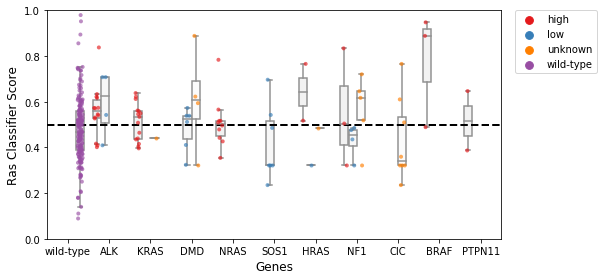

In [10]:
vis_classifier_scores(df=ras_df,
                      gene='Ras',
                      confidence_color_dict=confidence_pal,
                      rcparam=(8.5, 4))

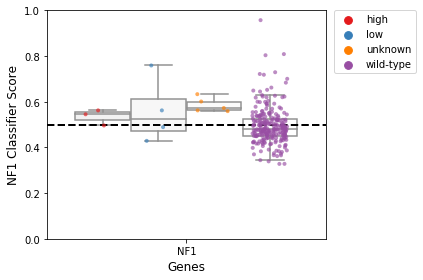

In [11]:
nf1_df.loc[nf1_df['Hugo_Symbol'] == 'wild-type', 'Hugo_Symbol'] = 'NF1'

vis_classifier_scores(df=nf1_df,
                      gene='NF1',
                      confidence_color_dict=confidence_pal)

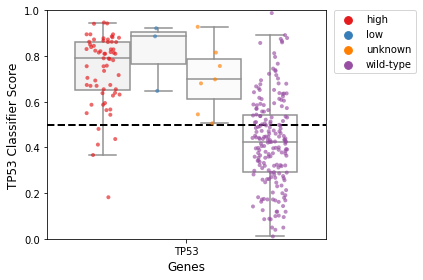

In [12]:
tp53_df.loc[tp53_df['Hugo_Symbol'] == 'wild-type', 'Hugo_Symbol'] = 'TP53'

vis_classifier_scores(df=tp53_df,
                      gene='TP53',
                      confidence_color_dict=confidence_pal)

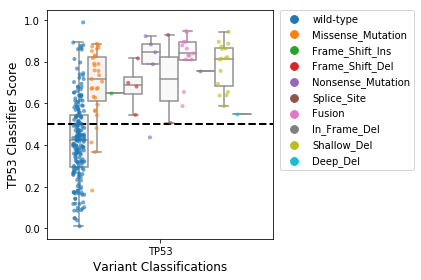

In [13]:
# Plot different variant classifications across TP53
file = os.path.join('figures', 'TP53_variant_classification.pdf')
ax = sns.boxplot(x='Hugo_Symbol',
                 y='tp53_score',
                 data=tp53_df,
                 hue='Variant_Classification',
                 color='white',
                 fliersize=0)

ax = sns.stripplot(x='Hugo_Symbol',
                   y='tp53_score',
                   data=tp53_df,
                   hue='Variant_Classification',
                   dodge=True,
                   edgecolor='black',
                   jitter=0.25,
                   size=4,
                   alpha=0.65)

ax.set_ylabel('TP53 Classifier Score', fontsize=12)
ax.set_xlabel('Variant Classifications', fontsize=12)
handles, labels = ax.get_legend_handles_labels()

lgd = plt.legend(handles[10:20], labels[10:20],
                 ncol=1,
                 bbox_to_anchor=(1.03, 1),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=10)

plt.axhline(linewidth=2, y=0.5, color='black', linestyle='dashed')
plt.tight_layout()
plt.savefig(file)

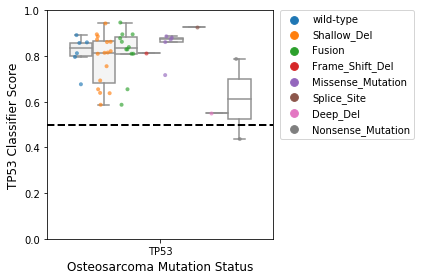

In [14]:
# Visualize Osteosarcoma Specifically
osteo_df = tp53_df[tp53_df["Histology-Detailed"] == "Osteosarcoma"]
file = os.path.join('figures', 'TP53_osteosarcoma_variant_classification.pdf')

ax = sns.boxplot(x='Hugo_Symbol',
                 y='tp53_score',
                 data=osteo_df,
                 hue='Variant_Classification',
                 color='white',
                 fliersize=0)

ax = sns.stripplot(x='Hugo_Symbol',
                   y='tp53_score',
                   data=osteo_df,
                   hue='Variant_Classification',
                   dodge=True,
                   edgecolor='black',
                   jitter=0.25,
                   size=4,
                   alpha=0.65)

ax.set_ylim([0, 1])
ax.set_ylabel('TP53 Classifier Score', fontsize=12)
ax.set_xlabel('Osteosarcoma Mutation Status', fontsize=12)
handles, labels = ax.get_legend_handles_labels()

lgd = plt.legend(handles[8:18], labels[8:18],
                 ncol=1,
                 bbox_to_anchor=(1.03, 1),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=10)

plt.axhline(linewidth=2, y=0.5, color='black', linestyle='dashed')
plt.tight_layout()
plt.savefig(file)

## 2. Extract Outliers

These are false positive and false negative samples.

In [15]:
# What are the outliers in TP53 mutated samples?
tp53_outlier_df = extract_outliers(df=tp53_df, gene='TP53')

In [16]:
# What are the outliers in Ras mutated samples?
ras_outlier_df = extract_outliers(df=ras_df, gene='Ras')

In [17]:
# What are the outliers in NF1 mutated samples?
nf1_outlier_df = extract_outliers(df=nf1_df, gene='NF1')

In [18]:
# Combine outliers into single dataframe
full_outlier_df = (
    pd.concat(
        [tp53_outlier_df, ras_outlier_df, nf1_outlier_df],
        axis='rows'
    )
    .sort_values(by='classifier_score', ascending=False)
    .drop_duplicates()
    .reset_index(drop=True)
)

full_outlier_df.head()

,sample_id,classifier_score,histology,hugo_symbol,true_status
0,NCH-RBD-1,0.988259,Rhabdoid,TP53,wild-type
1,NCH-RBD-2,0.979463,Rhabdoid,Ras,wild-type
2,NCH-RBD-1,0.957269,Rhabdoid,NF1,wild-type
3,OS-49-SJ,0.952093,Osteosarcoma,Ras,wild-type
4,IC-6634GBM,0.894246,Glioblastoma,Ras,wild-type


In [19]:
file = os.path.join("results", "outlier_predictions_ras_tp53_nf1.tsv")
full_outlier_df.to_csv(file, sep='\t', index=False)